---
### Use the Taxi v2 environment:
https://www.gymlibrary.dev/environments/toy_text/taxi/

#### Learn the policy using the following algorithms (Let parameters α = 0.4, γ=  0.9, Ɛ= 0.9):
- 1. SARSA
- 2. Expected SARSA
#### Plot the episode vs. reward graph, compare, and comment on the performance of the three algorithms for 2000 episodes.
---

=== Training SARSA (α=0.4, γ=0.9, ε=0.9) ===
Episode 500: Avg Reward = -687.31
Episode 1000: Avg Reward = -680.47
Episode 1500: Avg Reward = -671.95
Episode 2000: Avg Reward = -669.21

=== Training Expected SARSA (α=0.4, γ=0.9, ε=0.9) ===
Episode 500: Avg Reward = -652.40
Episode 1000: Avg Reward = -615.57
Episode 1500: Avg Reward = -611.87
Episode 2000: Avg Reward = -604.48


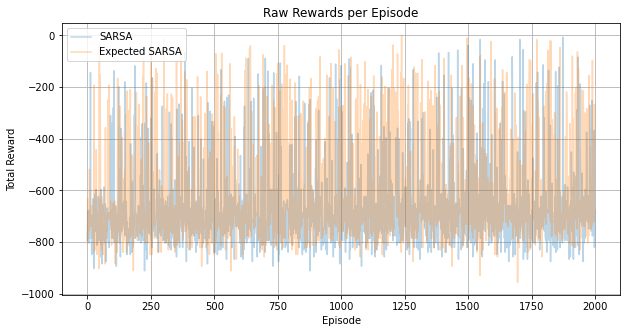

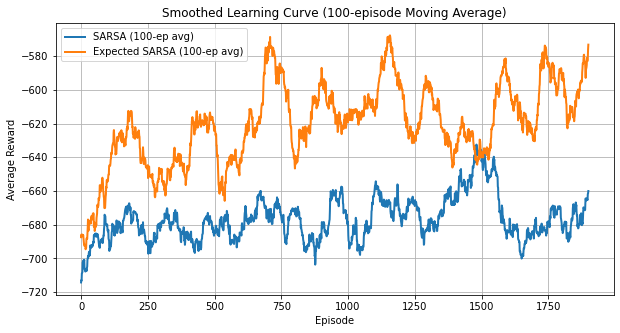


Final Performance (last 100 episodes):
SARSA: -660.02 | Expected SARSA: -573.21


In [4]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

class TaxiAgent:
    def __init__(self, env, learning_rate=0.4, gamma=0.9, epsilon=0.9, algorithm='sarsa'):
        self.env = env
        self.alpha = learning_rate  # Learning rate
        self.gamma = gamma          # Discount factor
        self.epsilon = epsilon      # Exploration rate (fixed at 0.9 as requested)
        self.algorithm = algorithm
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        return np.argmax(self.q_table[state])      # Exploit

    def update(self, state, action, reward, next_state, done):
        if self.algorithm == 'sarsa':
            next_action = self.choose_action(next_state)
            target = reward + (not done) * self.gamma * self.q_table[next_state][next_action]
        elif self.algorithm == 'expected_sarsa':
            policy = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            policy[np.argmax(self.q_table[next_state])] += (1 - self.epsilon)
            target = reward + (not done) * self.gamma * np.sum(policy * self.q_table[next_state])
        
        self.q_table[state][action] += self.alpha * (target - self.q_table[state][action])

def train_agent(agent, env, episodes=2000, log_interval=500):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
        
        rewards.append(episode_reward)
        
        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")

    return rewards

# Main execution
env = gym.make('Taxi-v3')

# Train SARSA
print("=== Training SARSA (α=0.4, γ=0.9, ε=0.9) ===")
sarsa_agent = TaxiAgent(env, algorithm='sarsa')
sarsa_rewards = train_agent(sarsa_agent, env)

# Train Expected SARSA
print("\n=== Training Expected SARSA (α=0.4, γ=0.9, ε=0.9) ===")
exp_sarsa_agent = TaxiAgent(env, algorithm='expected_sarsa')
exp_sarsa_rewards = train_agent(exp_sarsa_agent, env)

# Plot raw rewards (separate figure)
plt.figure(figsize=(10, 5))
plt.plot(sarsa_rewards, alpha=0.3, label='SARSA')
plt.plot(exp_sarsa_rewards, alpha=0.3, label='Expected SARSA')
plt.title('Raw Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# Plot smoothed rewards (separate figure)
plt.figure(figsize=(10, 5))
window = 100
plt.plot(np.convolve(sarsa_rewards, np.ones(window)/window, mode='valid'), 
         label='SARSA (100-ep avg)', linewidth=2)
plt.plot(np.convolve(exp_sarsa_rewards, np.ones(window)/window, mode='valid'), 
         label='Expected SARSA (100-ep avg)', linewidth=2)
plt.title('Smoothed Learning Curve (100-episode Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()

# Final comparison
final_sarsa = np.mean(sarsa_rewards[-100:])
final_exp_sarsa = np.mean(exp_sarsa_rewards[-100:])
print(f"\nFinal Performance (last 100 episodes):")
print(f"SARSA: {final_sarsa:.2f} | Expected SARSA: {final_exp_sarsa:.2f}")

---
### Previous version
---

EXPECTED_SARSA: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.18it/s]


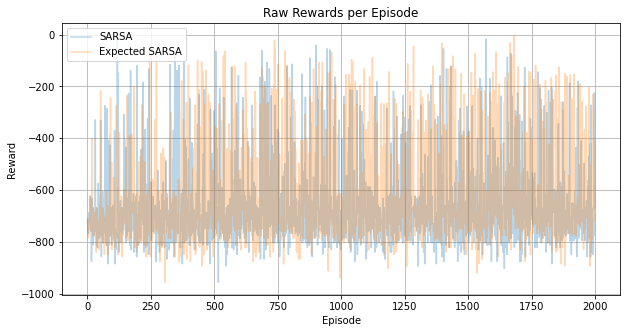

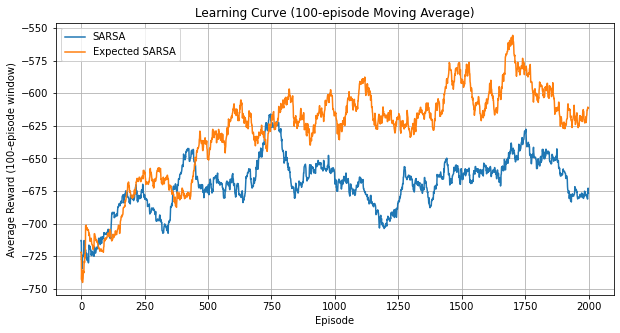

SARSA - Final Average Reward (last 100 episodes): -676.73
Expected SARSA - Final Average Reward (last 100 episodes): -611.23


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
from tqdm import tqdm

# Create the Taxi environment
env = gym.make('Taxi-v3')

class Agent:
    def __init__(self, algorithm='sarsa', alpha=0.4, gamma=0.9, epsilon=0.9, nA=6):
        """ Initialize agent.
        Params
        ======
        - algorithm: 'sarsa' or 'expected_sarsa'
        - alpha: learning rate
        - gamma: discount factor
        - epsilon: exploration rate
        - nA: number of actions
        """
        self.algorithm = algorithm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return np.random.choice(self.nA)
    
    def get_probs(self, Q_s):
        """Get action probabilities for epsilon-greedy policy"""
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - self.epsilon + (self.epsilon / self.nA)
        return policy_s
    
    def update_Q(self, state, action, reward, next_state=None, next_action=None, done=False):
        """Update Q-values based on the algorithm"""
        current = self.Q[state][action]
        
        if done:
            target = reward
        else:
            if self.algorithm == 'sarsa':
                # SARSA update
                target = reward + self.gamma * self.Q[next_state][next_action]
            elif self.algorithm == 'expected_sarsa':
                # Expected SARSA update
                policy_s = self.get_probs(self.Q[next_state])
                target = reward + self.gamma * np.sum(policy_s * self.Q[next_state])
            else:
                raise ValueError("Unknown algorithm")
                
        # Update Q-value
        self.Q[state][action] = current + self.alpha * (target - current)

def run_experiment(algorithm, num_episodes=2000):
    """Run experiment with specified algorithm"""
    agent = Agent(algorithm=algorithm, alpha=0.4, gamma=0.9, epsilon=0.9)
    rewards = []
    avg_rewards = []
    
    for episode in tqdm(range(num_episodes), desc=f"{algorithm.upper()}"):
        state = env.reset()
        if isinstance(state, tuple):  # Handle newer Gym versions
            state = state[0]
        action = agent.select_action(state)
        total_reward = 0
        done = False
        
        while not done:
            step_result = env.step(action)
            if len(step_result) == 4:  # Older Gym versions
                next_state, reward, done, _ = step_result
            else:  # Newer Gym versions (v0.26+)
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            
            total_reward += reward
            
            if not done:
                next_action = agent.select_action(next_state)
                agent.update_Q(state, action, reward, next_state, next_action, done)
                action = next_action
            else:
                agent.update_Q(state, action, reward, done=done)
                
            state = next_state
        
        rewards.append(total_reward)
        
        # Calculate running average
        if episode >= 100:
            avg_rewards.append(np.mean(rewards[-100:]))
        else:
            avg_rewards.append(np.mean(rewards))
    
    return rewards, avg_rewards

# Run experiments
num_episodes = 2000
sarsa_rewards, sarsa_avg = run_experiment('sarsa', num_episodes)
expected_sarsa_rewards, expected_sarsa_avg = run_experiment('expected_sarsa', num_episodes)

# Plot raw rewards separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_rewards, label='SARSA', alpha=0.3)
plt.plot(expected_sarsa_rewards, label='Expected SARSA', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Raw Rewards per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot moving averages separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_avg, label='SARSA')
plt.plot(expected_sarsa_avg, label='Expected SARSA')
plt.xlabel('Episode')
plt.ylabel('Average Reward (100-episode window)')
plt.title('Learning Curve (100-episode Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

# Print final performance
print(f"SARSA - Final Average Reward (last 100 episodes): {np.mean(sarsa_rewards[-100:]):.2f}")
print(f"Expected SARSA - Final Average Reward (last 100 episodes): {np.mean(expected_sarsa_rewards[-100:]):.2f}")

--------

#### printing reward for each episode

Running SARSA...


SARSA: 100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.81it/s]



Running Expected SARSA...


EXPECTED_SARSA: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.95it/s]



Episode-by-Episode Rewards:
Episode    SARSA      Expected SARSA 
1          -731.00    -695.00        
2          -659.00    -830.00        
3          -632.00    -758.00        
4          -713.00    -677.00        
5          -731.00    -722.00        
6          -731.00    -704.00        
7          -677.00    -740.00        
8          -659.00    -731.00        
9          -614.00    -731.00        
10         -578.00    -668.00        
11         -677.00    -713.00        
12         -695.00    -722.00        
13         -695.00    -695.00        
14         -839.00    -776.00        
15         -448.00    -785.00        
16         -812.00    -704.00        
17         -107.00    -731.00        
18         -695.00    -713.00        
19         -776.00    -659.00        
20         -785.00    -812.00        
21         -776.00    -614.00        
22         -812.00    -803.00        
23         -749.00    -830.00        
24         -803.00    -794.00        
25         -767.00   

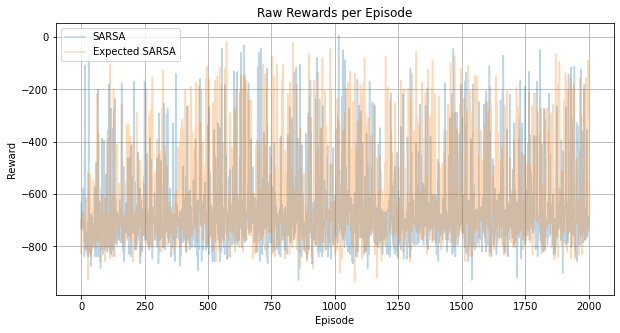

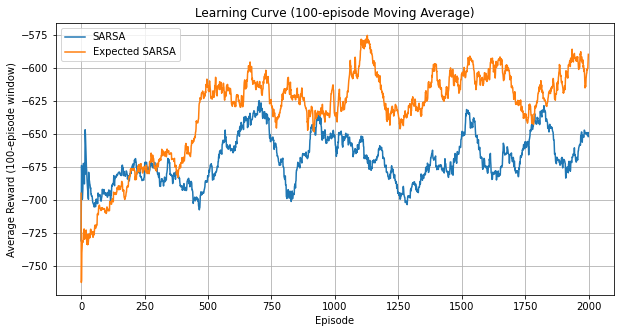


SARSA - Final Average Reward (last 100 episodes): -652.09
Expected SARSA - Final Average Reward (last 100 episodes): -589.89

Expected SARSA performed better in the final 100 episodes


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
from tqdm import tqdm

# Create the Taxi environment
env = gym.make('Taxi-v3')

class Agent:
    def __init__(self, algorithm='sarsa', alpha=0.4, gamma=0.9, epsilon=0.9, nA=6):
        """ Initialize agent.
        Params
        ======
        - algorithm: 'sarsa' or 'expected_sarsa'
        - alpha: learning rate
        - gamma: discount factor
        - epsilon: exploration rate
        - nA: number of actions
        """
        self.algorithm = algorithm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return np.random.choice(self.nA)
    
    def get_probs(self, Q_s):
        """Get action probabilities for epsilon-greedy policy"""
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - self.epsilon + (self.epsilon / self.nA)
        return policy_s
    
    def update_Q(self, state, action, reward, next_state=None, next_action=None, done=False):
        """Update Q-values based on the algorithm"""
        current = self.Q[state][action]
        
        if done:
            target = reward
        else:
            if self.algorithm == 'sarsa':
                # SARSA update
                target = reward + self.gamma * self.Q[next_state][next_action]
            elif self.algorithm == 'expected_sarsa':
                # Expected SARSA update
                policy_s = self.get_probs(self.Q[next_state])
                target = reward + self.gamma * np.sum(policy_s * self.Q[next_state])
            else:
                raise ValueError("Unknown algorithm")
                
        # Update Q-value
        self.Q[state][action] = current + self.alpha * (target - current)

def run_experiment(algorithm, num_episodes=2000):
    """Run experiment with specified algorithm"""
    agent = Agent(algorithm=algorithm, alpha=0.4, gamma=0.9, epsilon=0.9)
    rewards = []
    avg_rewards = []
    
    for episode in tqdm(range(num_episodes), desc=f"{algorithm.upper()}"):
        state = env.reset()
        if isinstance(state, tuple):  # Handle newer Gym versions
            state = state[0]
        action = agent.select_action(state)
        total_reward = 0
        done = False
        
        while not done:
            step_result = env.step(action)
            if len(step_result) == 4:  # Older Gym versions
                next_state, reward, done, _ = step_result
            else:  # Newer Gym versions (v0.26+)
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            
            total_reward += reward
            
            if not done:
                next_action = agent.select_action(next_state)
                agent.update_Q(state, action, reward, next_state, next_action, done)
                action = next_action
            else:
                agent.update_Q(state, action, reward, done=done)
                
            state = next_state
        
        rewards.append(total_reward)
        
        # Calculate running average
        if episode >= 100:
            avg_rewards.append(np.mean(rewards[-100:]))
        else:
            avg_rewards.append(np.mean(rewards))
    
    return rewards, avg_rewards

# Run experiments
num_episodes = 2000
print("Running SARSA...")
sarsa_rewards, sarsa_avg = run_experiment('sarsa', num_episodes)

print("\nRunning Expected SARSA...")
expected_sarsa_rewards, expected_sarsa_avg = run_experiment('expected_sarsa', num_episodes)

# Print rewards for all episodes
print("\nEpisode-by-Episode Rewards:")
print(f"{'Episode':<10} {'SARSA':<10} {'Expected SARSA':<15}")
for ep in range(num_episodes):
    print(f"{ep+1:<10} {sarsa_rewards[ep]:<10.2f} {expected_sarsa_rewards[ep]:<15.2f}")

# Plot raw rewards separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_rewards, label='SARSA', alpha=0.3)
plt.plot(expected_sarsa_rewards, label='Expected SARSA', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Raw Rewards per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot moving averages separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_avg, label='SARSA')
plt.plot(expected_sarsa_avg, label='Expected SARSA')
plt.xlabel('Episode')
plt.ylabel('Average Reward (100-episode window)')
plt.title('Learning Curve (100-episode Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

# Print final performance
print(f"\nSARSA - Final Average Reward (last 100 episodes): {np.mean(sarsa_rewards[-100:]):.2f}")
print(f"Expected SARSA - Final Average Reward (last 100 episodes): {np.mean(expected_sarsa_rewards[-100:]):.2f}")

# Performance comparison
if np.mean(sarsa_rewards[-100:]) > np.mean(expected_sarsa_rewards[-100:]):
    print("\nSARSA performed better in the final 100 episodes")
else:
    print("\nExpected SARSA performed better in the final 100 episodes")